In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns 

In [3]:
#Create a list called words that contains the name column of df

df = pd.read_csv('turkce_isimler.csv')
words = df['name'].tolist()

In [9]:
print(min(len(w) for w in words))
print(max(len(w) for w in words))

2
14


freq_list

In [21]:
freq_list = [ch1 for w in words for ch1 in w]
freq_list[:8]

['a', 'b', 'a', 'a', 'b', 'a', 'c', 'a']

In [22]:
len(freq_list)

87393

In [24]:
class language_model:
      def __init__(self, freq_list):
            self.freq_list = freq_list
      def predict(self):
            output = np.random.rand(len(freq_list))
            output = output/sum(output)
            return output
model = language_model(freq_list)

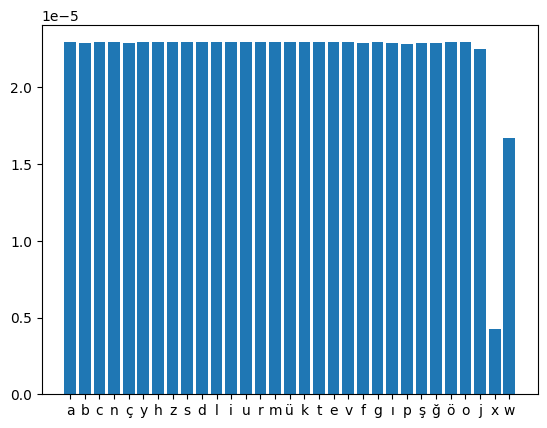

In [25]:
predictions = model.predict()
plt.bar(freq_list, predictions)
plt.show()

In [26]:
predictions.sum()

1.0000000000000127

# 2. SAMPLING BY GREEDY SEARCH

Greedy search method simply seelcts the token with the highest probability as its next token (word or char).

However, if we always sample the most likely word, the standard language model training objective causes us to **get stuck in loops** like 

***"I don't know.I don't know.I don't know."***

In [31]:
def greedy_search(conditional_probability):
      return (np.argmax(conditional_probability))

next_token = greedy_search(predictions)
print(f"Sampled token: {freq_list[next_token]} with probability {predictions[next_token]}")

Sampled token: n with probability 2.2925184155189943e-05


# 3. TEMPERATURE SAMPLING:

Temperature sampling is inspired by statistical thermodynamics, where high temperature means low energy states are more likely encountered.

In probabiility models, logits play the role of energy and we can implement temperature sampling by **dividing logits by the temperature** before feeding them into ***softmax*** and obtaining our sampling probabilites. 

## 3.1 Reweighting the distribution to a certain temperature

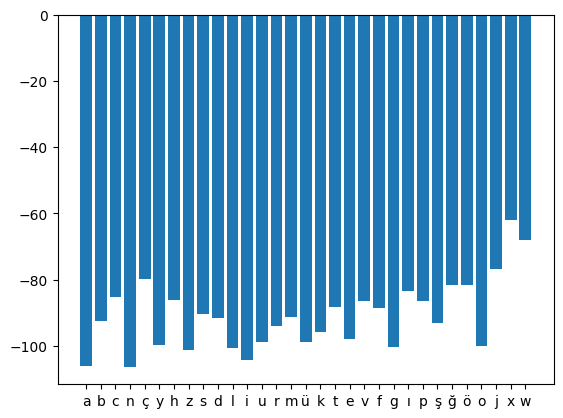

In [32]:
temperature = 0.2 
conditional_probability = np.asarray(predictions).astype("float32")
conditional_probability = np.log(conditional_probability) / temperature
plt.bar(freq_list, conditional_probability)
plt.show()

## 3.2 Applying **softmax** function

The softmax function transforms each element of a collection by computing the **exponential of each element ***divided*** by** the **sum of the exponenetials of all** the elements. That is , if x is one-dimensional numpy array: 

$$ \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K $$

We can define our own function or use ```scipy.special.softmax``` ```torch.nn.functional.softmax```

Here we will define our own softmax.

In [33]:
def softmax(z):
      return np.exp(z) / np.sum(np.exp(z))

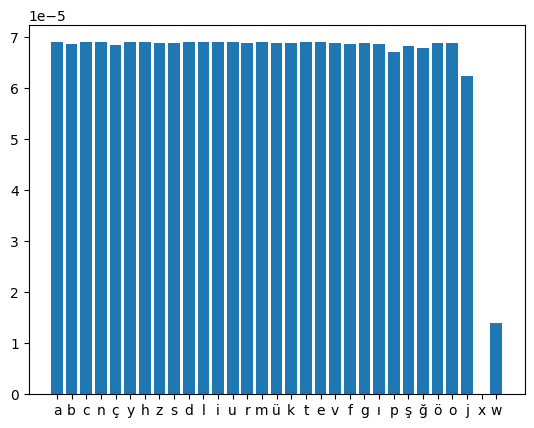

In [34]:
reweighted_conditional_probability = softmax(conditional_probability)
plt.bar(freq_list, reweighted_conditional_probability)
plt.show()

## 3.3 Sampling the next character randomly according to the reweighted distribution

We can draw a sample using ***multinomial distribution*** 
The **parameters** of the multinomial distribution function are:
 * **n**: int, Number of experiments.
 * **pvals**: sequence of floats, length p. Probabilities of each of the p different outcomes. These must sum to 1 (however, the last element is always assumed to account for the remaining probabilty as long as sum (pvals[:1] <= 1)).
 * **size**: int or tuple of ints, optianl. Output shape. If the given shape is, e.g., (m,n,k) then m*n*k samples are drawn. Default is none, in which case a single value is returned. 

We will call multinomial distribution function with the parameters ```(1, reweighted_conditional_probability, 1)``` because we want only 1 **draw experiment** from **reweighted_conditional_probability** to select (sample) 1 **output**

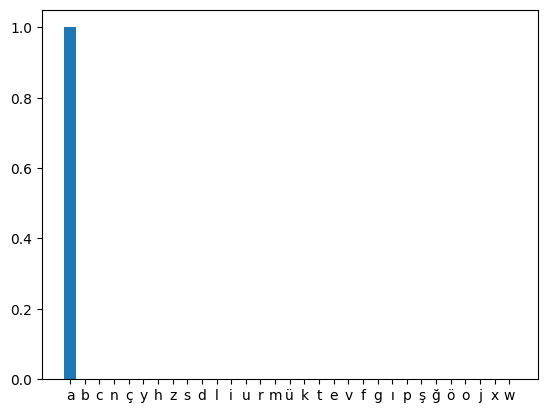

In [35]:
probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
plt.bar(freq_list, np.squeeze(probas))
plt.show()

In [36]:
# Putting all in one function

def temperature_sampling(conditional_probability, temperature=1.0):
      conditional_probability = np.asarray(conditional_probability).astype("float32")
      conditional_probability = np.log(conditional_probability) / temperature
      reweighted_conditional_probability = softmax(conditional_probability)
      probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
      plt.bar(freq_list, reweighted_conditional_probability)
      plt.show()
      return np.argmax(probas)

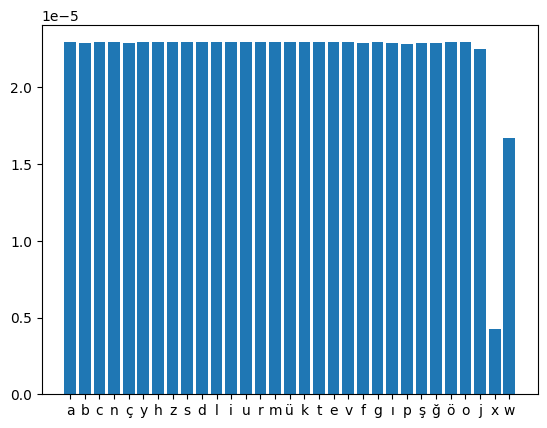

In [37]:
plt.bar(freq_list, predictions)
plt.show()

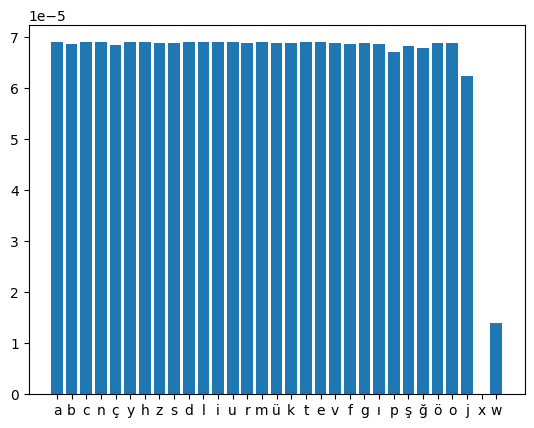

Temperature:  0.2
Sampled token:  a 



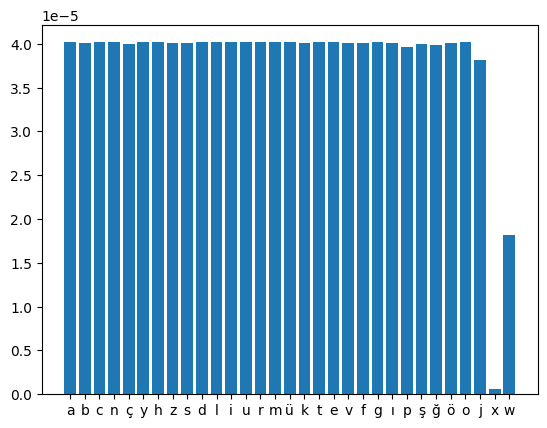

Temperature:  0.4
Sampled token:  i 



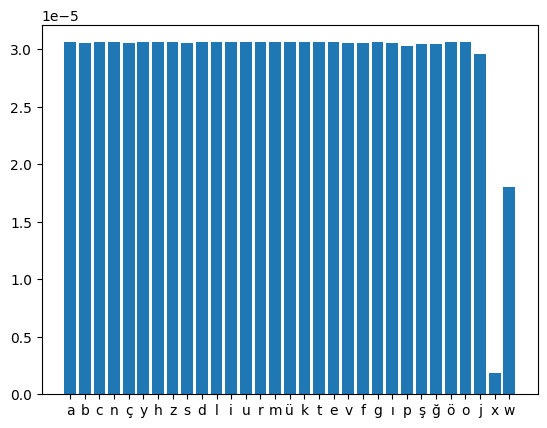

Temperature:  0.6000000000000001
Sampled token:  k 



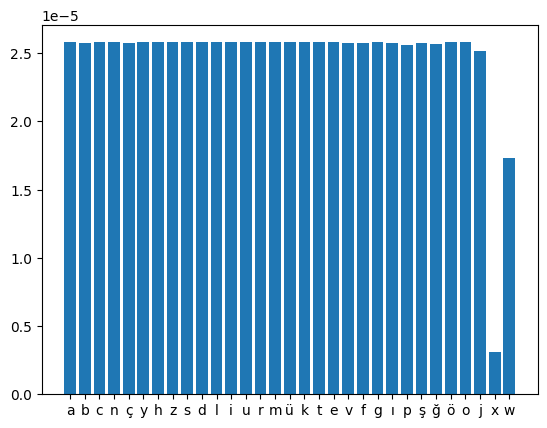

Temperature:  0.8
Sampled token:  e 



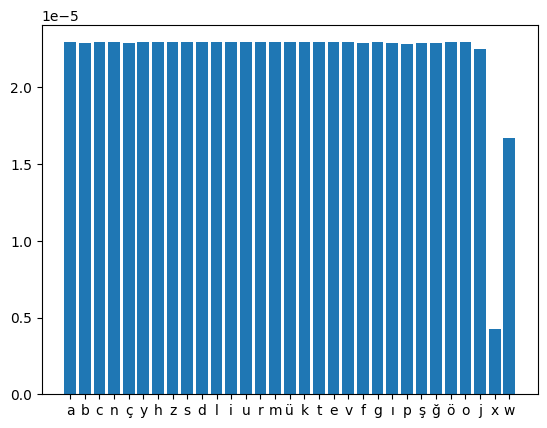

Temperature:  1.0
Sampled token:  a 



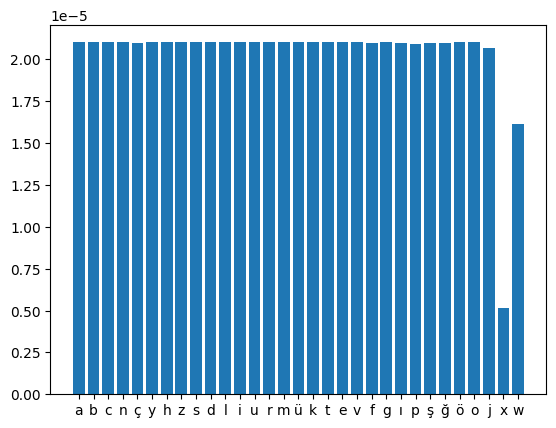

Temperature:  1.2
Sampled token:  o 



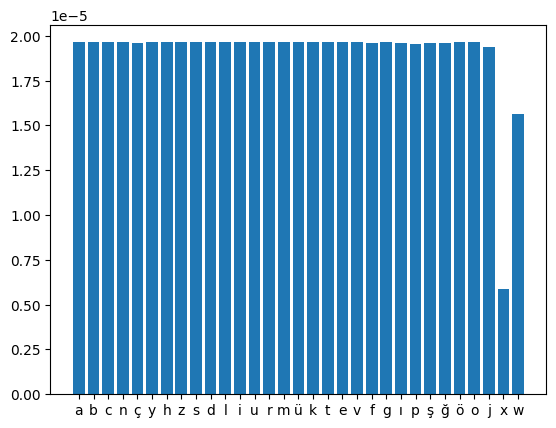

Temperature:  1.4000000000000001
Sampled token:  b 



In [38]:
for temp in np.arange(0.2,1.6,0.2):
  
  next_token = temperature_sampling(predictions, temperature=temp)
  print("Temperature: ", temp)
  print("Sampled token: ",freq_list[next_token],"\n")


## 3.5 Obserations

In most of researches, it is noted that:
 * If **temperature** is set to **very low values or 0** then Temperature Sampling becomes **equivalent** to **Greedy Search** by always picking the next token with the highest probablity.
 * A **low temperature** results in extremely **repetitive** and **predictable** text, but where local structure is highly **realistic**: in particular, all words (a word being a local pattern of characters) are real words from the corpus.
 * With **higher temperatures**, the generated text becomes more **random**, **interesting**, **surprising**, even creative; it may sometimes invent completely new words(*misspelled words*) that sound somewhat **plausible** 
 * With a **high temperature**, the local structure starts breaking down and most words look like **semi-random strings** of characters.
 * Always **experiment with multiple temperature values**! A clever balance between leearned structure and randomness is what makes generation interesting.

# 4. TOP-K SAMPLING

[Fan et. al (2018)](https://arxiv.org/abs/1805.04833) introduced a simple, but very powerful sampling scheme, called Top-K sampling. 

In Top-K sampling, the **K most likely next words** are filtered and the **probability** mass is **redistributed** among only those K next words. 

**GPT2** adopted this sampling scheme, which was one of the reasons for its success in **story generation**.

To apply the Top-k sampling, we sort all the tokens accoding to the probabilites and zero-ing out the probabilities for anything below the k’th token. 



https://colab.research.google.com/drive/1yK5LO4jAPb8LHAoQWw0svH6p8QSiDcwC?usp=sharing#scrollTo=mmJJWNm3YwNB